In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
sns.set_style("whitegrid")

In [4]:
summary = pd.read_csv("atussum_2013.dat")
summary.info()

def linear_least_squares(df, fn):
    values = df.index.map(fn)
    diffs = df.mean_minutes - values
    diffs_squared = diffs ** 2
    return diffs_squared.sum() / (2 * len(diffs)) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [5]:
sleep_data = summary[['TUFINLWGT', 'TEAGE', 'TESEX', 't010101']]
sleep_data = sleep_data.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", "TESEX": "sex", "t010101": "minutes"})
sleep_data['weighted_minutes'] = sleep_data.weight * sleep_data.minutes
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Data columns (total 5 columns):
weight              11385 non-null float64
age                 11385 non-null int64
sex                 11385 non-null int64
minutes             11385 non-null int64
weighted_minutes    11385 non-null float64
dtypes: float64(2), int64(3)
memory usage: 533.7 KB


In [6]:
sleep_by_age = sleep_data.groupby("age").sum()
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes
age,,,,
15,1.168895e+09,159,62992,6.645155e+11
16,1.807565e+09,243,96196,1.013404e+12
17,1.929189e+09,246,96861,1.094304e+12
18,1.419704e+09,165,64722,8.498931e+11
19,1.307960e+09,130,50557,7.508169e+11


In [7]:
sleep_by_age['mean_minutes'] = sleep_by_age.weighted_minutes / sleep_by_age.weight
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes,mean_minutes
age,,,,,
15,1.168895e+09,159,62992,6.645155e+11,568.498993
16,1.807565e+09,243,96196,1.013404e+12,560.646005
17,1.929189e+09,246,96861,1.094304e+12,567.235373
18,1.419704e+09,165,64722,8.498931e+11,598.641088
19,1.307960e+09,130,50557,7.508169e+11,574.036484


Grab the age 37 and lets see how much sleep they get

In [14]:
sleep_by_age.loc[37].mean_minutes/60

8.152801822258235

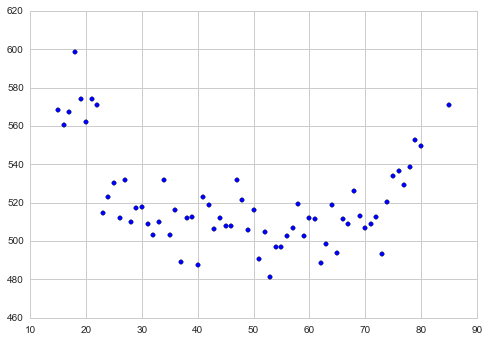

In [15]:
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
plt.show()

#### Let's create a linear regression model

In [16]:
regression = linear_model.LinearRegression()
transposed_sleep_values = np.array(sleep_by_age.index.values).reshape((-1, 1))
regression.fit(transposed_sleep_values, sleep_by_age.mean_minutes.values)
print(regression.coef_, regression.intercept_)

[-0.3727603] 538.764180347


#### Save some time later and set up the line creation overlay

In [19]:
def plot_regression(fn):
    plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
    xmin, xmax = plt.xlim()
    xs = np.linspace(xmin, xmax, 100)
    plt.plot(xs, [fn(x) for x in xs])
    plt.show()

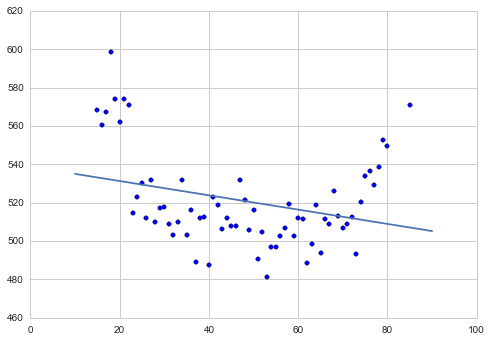

0.086941602635587478

In [30]:
fn = lambda x: regression.predict(x)[0]

plot_regression(fn)
regression.score(transposed_sleep_values, sleep_by_age.mean_minutes.values)

####Well that looks very wrong

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [26]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)

[  6.45733647e+02  -5.66518847e+00   5.48318311e-02]


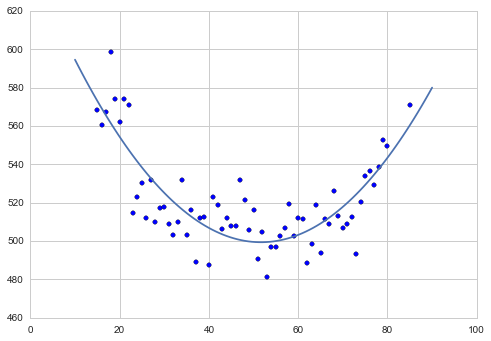

0.67815914472774552

In [33]:
fn = lambda x: model.predict(x)[0]
plot_regression(fn)
model.score((sleep_by_age.index.values).reshape((-1, 1)), sleep_by_age.mean_minutes.values)

#### Now predictions make sense

In [34]:
model.predict(32) / 60

array([ 8.67659018])

In [35]:
model.predict(50) / 60

array([ 8.32589668])

### Several degrees of poly

#### Zero

[ 520.84943152]


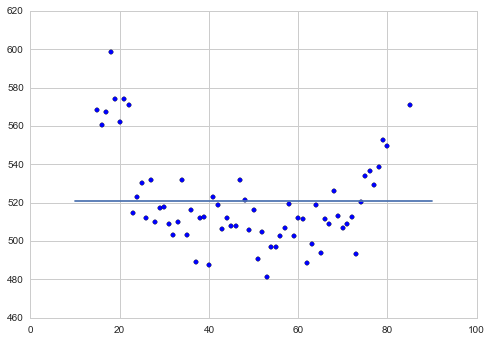

0.0

In [37]:
model = Pipeline([('poly', PolynomialFeatures(degree=0)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)


print(model.named_steps['linear'].coef_)

fn = lambda x: model.predict(x)[0]

plot_regression(fn)
model.score(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

#### One (This is the same as the original line)

[  5.38764180e+02  -3.72760302e-01]


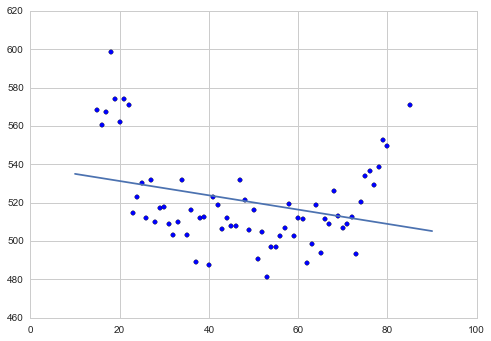

0.086941602635587145

In [39]:
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)

fn = lambda x: model.predict(x)[0]

plot_regression(fn)
model.score(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

[  0.00000000e+00  -1.96775534e+01   4.95578215e-01  -4.70230260e-03
  -1.15898708e-06   1.87993805e-07]


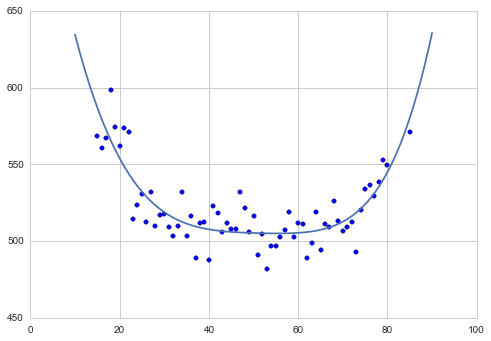

0.72521711883999118

In [40]:
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                  ('linear', LinearRegression())])
model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
fn = lambda x: model.predict(x)[0]

plot_regression(fn)
model.score(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

[  0.00000000e+00  -4.12828643e-05  -9.08344345e-06  -1.56606931e-04
  -1.54756470e-03   1.10207603e-04  -3.18351478e-06   4.61845298e-08
  -3.34619263e-10   9.66018225e-13  -7.95726712e-19]


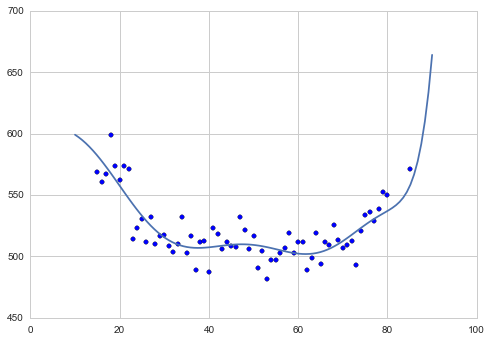

0.74810791951034128

In [41]:
model = Pipeline([('poly', PolynomialFeatures(degree=10)),
                  ('linear', LinearRegression())])
model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
fn = lambda x: model.predict(x)[0]

plot_regression(fn)
model.score(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)